![Colegio Bourbaki](./Images/Bourbaki.png)

## Machine Learning & AI

## Introduccion a Convolutional Neural Networks

In [1]:
# Pytorch
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torch.nn import (
    Module,
    Conv2d,
    BatchNorm2d,
    MaxPool2d,
    Dropout2d,
    Linear,
    BatchNorm1d,
    ReLU,
    Dropout,
    CrossEntropyLoss,
)
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Utils
import pandas as pd
import numpy as np
import os
import sys
from collections import Counter
from PIL import Image
from torchsummary import summary
from tqdm.notebook import tqdm

# Metrics & Calibration
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
    brier_score_loss,
    roc_auc_score,
)
from sklearn.calibration import calibration_curve
from matplotlib.gridspec import GridSpec

### Configuraciones

In [2]:
# Set seed for random generators
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [3]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
!set 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:2'
torch.cuda.empty_cache()
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False

In [4]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

In [5]:
device

'cuda:0'

In [6]:
print("__Python VERSION:", sys.version)
print("__pyTorch VERSION:", torch.__version__)
print(
    "__CUDA VERSION",
)
! nvidia-smi
print("__CUDNN VERSION:", torch.backends.cudnn.version())
print("__Number CUDA Devices:", torch.cuda.device_count())
print("__Devices")
print("Active CUDA Device: GPU", torch.cuda.current_device())
print("Available devices ", torch.cuda.device_count())
print("Current cuda device ", torch.cuda.current_device())

__Python VERSION: 3.11.8 (main, Feb  9 2024, 16:48:53) [GCC 11.4.0]
__pyTorch VERSION: 2.2.0+cu121
__CUDA VERSION
Mon Feb 12 11:01:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti     On  | 00000000:01:00.0  On |                  N/A |
| N/A   55C    P0              13W /  50W |     95MiB /  4096MiB |     17%      Default |
|                                         | 

__CUDNN VERSION: 8902
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


### Contexto

El conjunto de datos está organizado en 3 carpetas (train, test, val) y contiene subcarpetas para cada categoría de imágenes (Pneumonia/Normal). Hay 5.863 imágenes de rayos X (JPEG) y 2 categorías (Neumonía/Normal).

Las imágenes de radiografía de tórax (anterior-posterior) se seleccionaron a partir de cohortes retrospectivas de pacientes pediátricos de uno a cinco años del Guangzhou Women and Children's Medical Center, Guangzhou. Todas las radiografías de tórax se realizaron como parte de la atención clínica rutinaria de los pacientes.

Para el análisis de las imágenes de rayos X de tórax, todas las radiografías de tórax se sometieron inicialmente a un control de calidad mediante la eliminación de todas las exploraciones de baja calidad o ilegibles. A continuación, dos médicos expertos clasificaron los diagnósticos de las imágenes antes de autorizarlos para el entrenamiento del sistema de IA. Para tener en cuenta cualquier error de clasificación, el conjunto de evaluación también fue revisado por un tercer experto.

Datos: https://data.mendeley.com/datasets/rscbjbr9sj/2

Licencia: CC BY 4.0 CC BY 4.0

Cita: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

Veamos una de las imágenes:

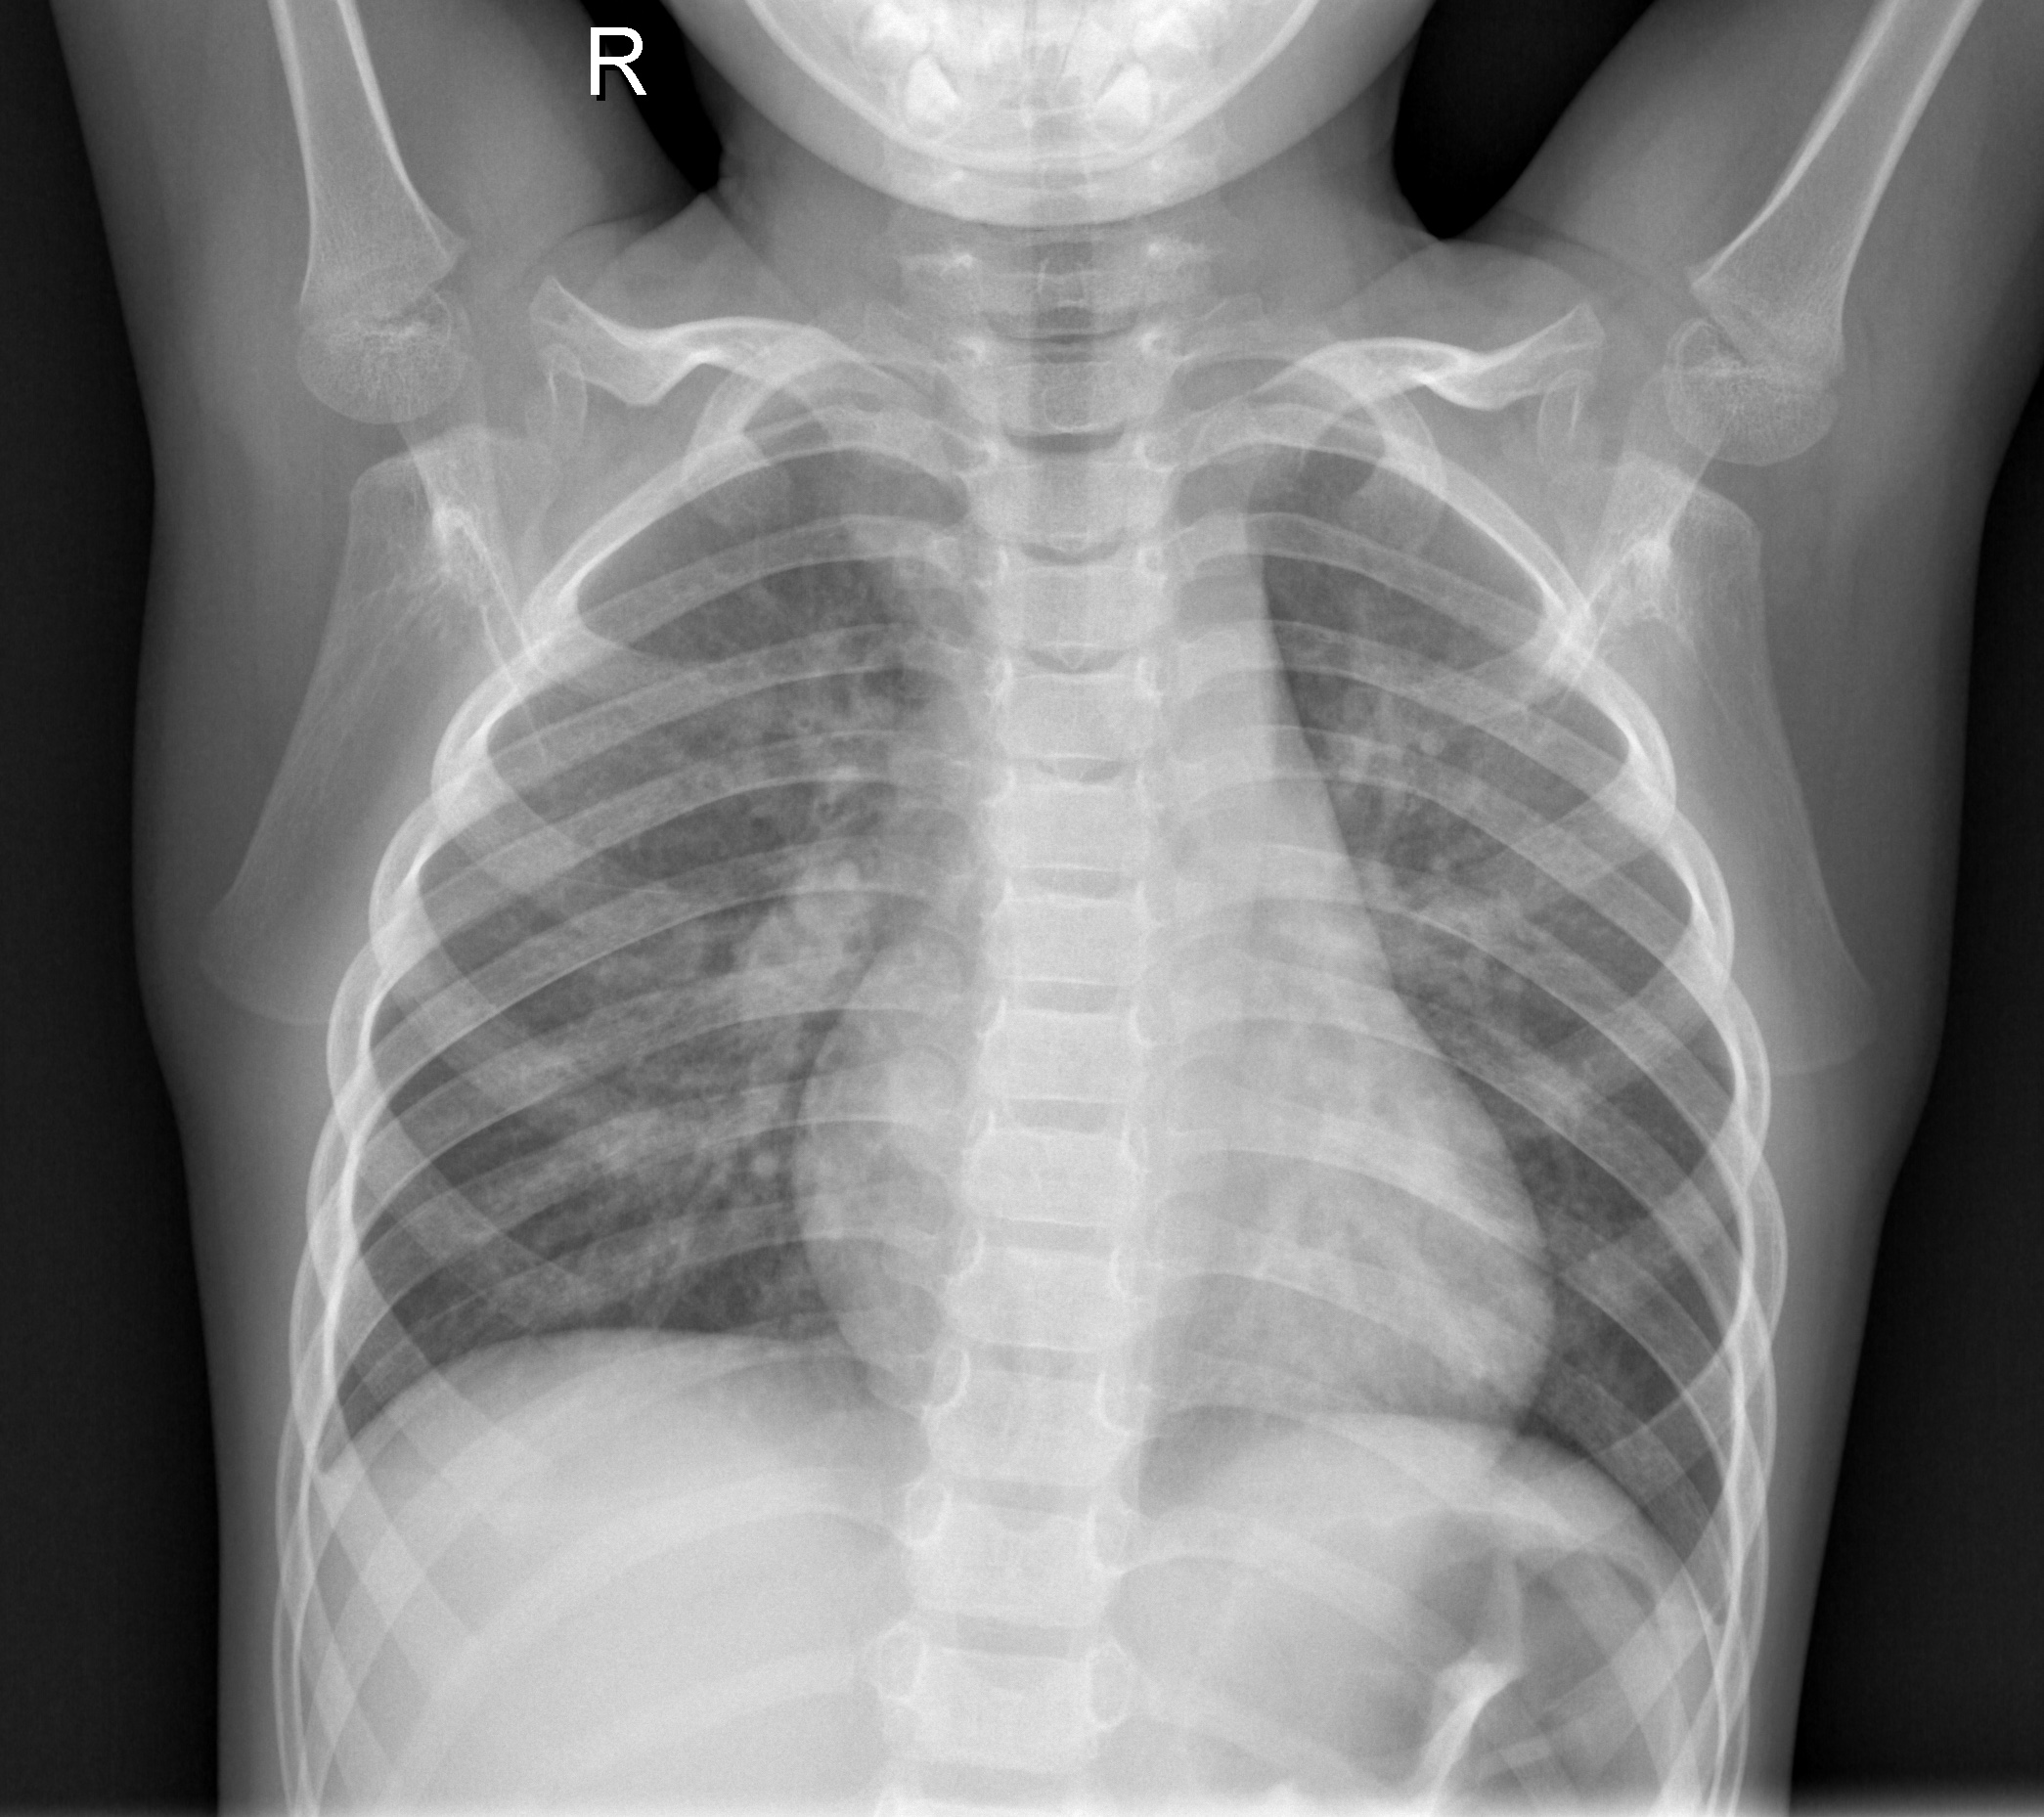

In [7]:
image_path = "./Data/chest_xray/train/NORMAL/IM-0115-0001.jpeg"

# Open the image
image = Image.open(image_path)

# Display the image
image

Vamos a chequear sus dimensiones:

In [8]:
# Get the width and height
width, height = image.size

# Print the width and height
print(f"Width: {width}, Height: {height}")

Width: 2090, Height: 1858


También vamos a chequear si la imágen está en escala de grises o RGB:

In [9]:
if image.mode == "L":
    channels = 1
elif image.mode == "RGB":
    channels = 3
elif image.mode == "RGBA":
    channels = 4
else:
    channels = (
        None  # For modes that don't directly map to a specific number of channels
    )

# Print the number of channels
if channels:
    print(f"Channels: {channels}")
else:
    print(
        f"Image mode '{image.mode}' is not directly mapped to a specific number of channels."
    )

Channels: 1


Vamos a definir los directorios donde se encuentran las imágenes que ya fueron segmentadas:

In [10]:
IMAGE_DIR_TRAIN = "./Data/chest_xray/train"
IMAGE_DIR_VAL = "./Data/chest_xray/val"
IMAGE_DIR_TEST = "./Data/chest_xray/test"

Definimos el nuevo tamaño de la imágen y aplicamos las transformaciones correspondientes:

In [11]:
SIZE = (128, 128)

In [12]:
transform = transforms.Compose(
    [
        transforms.Grayscale(),
        transforms.Resize(SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

Construimos los datasets correspondientes:

In [13]:
train_dataset = ImageFolder(IMAGE_DIR_TRAIN, transform=transform)
val_dataset = ImageFolder(IMAGE_DIR_VAL, transform=transform)
test_dataset = ImageFolder(IMAGE_DIR_TEST, transform=transform)

In [14]:
train_dataset[0][0].shape

torch.Size([1, 128, 128])

Construimos los dataloaders correspondientes:

In [15]:
BATCH_SIZE = 128

In [16]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Vamos a inspeccionar la distribución de las imágenes:

In [17]:
print(f"Classes: {train_dataset.class_to_idx}")
num_classes_train = Counter(train_dataset.targets)
num_classes_val = Counter(val_dataset.targets)
print(f"Train Dataset: {num_classes_train}")
print(f"Val Dataset: {num_classes_val}")

Classes: {'NORMAL': 0, 'PNEUMONIA': 1}
Train Dataset: Counter({1: 3875, 0: 1341})
Val Dataset: Counter({0: 8, 1: 8})


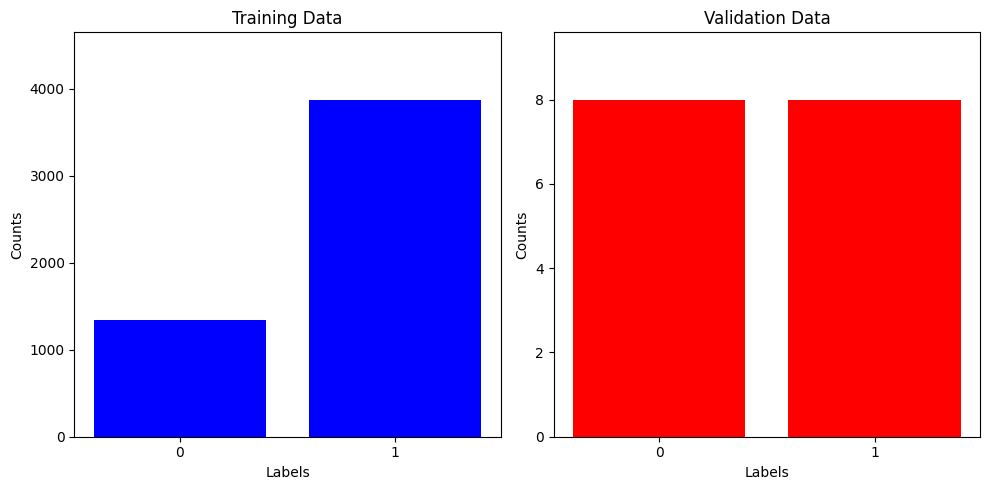

In [18]:
# Convert dictionaries to ordered lists for plotting
labels = list(num_classes_train.keys())  # Labels are '0' and '1'
train_values = list(num_classes_train.values())
val_values = list(num_classes_val.values())
x_ticks_positions = np.arange(len(labels))  # Positions for labels on the x-axis

# Set up the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot training data on the first subplot
ax1.bar(x_ticks_positions, train_values, color="blue", tick_label=labels)
ax1.set_title("Training Data")
ax1.set_xlabel("Labels")
ax1.set_ylabel("Counts")
ax1.set_ylim(0, max(train_values) * 1.2)  # Set y-axis limit for clarity
ax1.set_xticks([0, 1])  # Set x-axis ticks to only show '0' and '1'

# Plot validation data on the second subplot
ax2.bar(x_ticks_positions, val_values, color="red", tick_label=labels)
ax2.set_title("Validation Data")
ax2.set_xlabel("Labels")
ax2.set_ylabel("Counts")
ax2.set_ylim(
    0, max(val_values) * 1.2
)  # Match y-axis limit with the first plot for consistency
ax2.set_xticks([0, 1])  # Set x-axis ticks to only show '0' and '1'

# Adjust layout for better spacing and display the plot
plt.tight_layout()
plt.show()

In [19]:
def show_images(num_samples, loader):
    # Initialize lists to hold sampled images and targets
    sampled_images = []
    sampled_targets = []

    # Sample up to num_samples images and targets from the DataLoader
    for images, targets in loader:
        for i in range(images.size(0)):
            sampled_images.append(images[i])
            sampled_targets.append(targets[i])
            if len(sampled_images) >= num_samples:
                break
        if len(sampled_images) >= num_samples:
            break

    # Determine the number of samples actually gathered
    actual_num_samples = len(sampled_images)

    # Setup for subplots based on the actual number of samples
    fig, axes = plt.subplots(
        nrows=1, ncols=actual_num_samples, figsize=(actual_num_samples * 2.5, 2.5)
    )
    if actual_num_samples == 1:
        axes = [axes]  # Making it iterable for consistency

    # Display the sampled images
    for idx, (img, target) in enumerate(zip(sampled_images, sampled_targets)):
        ax = axes[idx]
        img = img.squeeze()  # Assuming grayscale for simplicity
        ax.imshow(img.numpy(), cmap="gray")  # Convert to numpy and display
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Tag: {target.item()}")

    plt.tight_layout()
    plt.show()

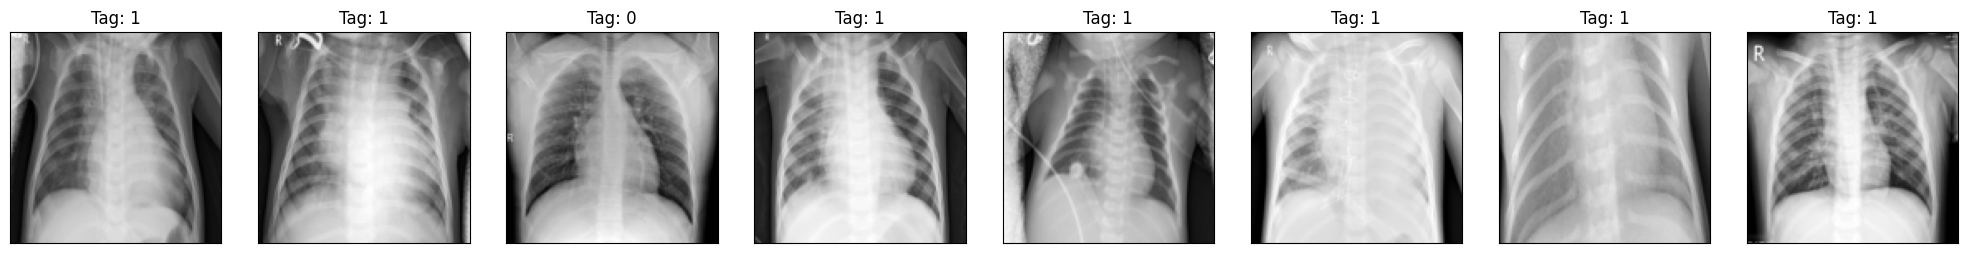

In [20]:
show_images(8, train_loader)

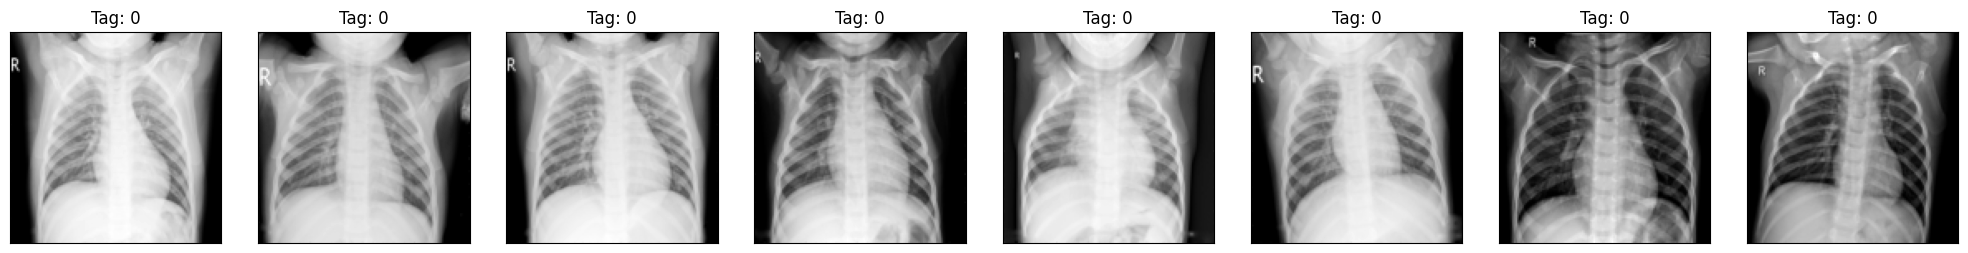

In [21]:
show_images(8, val_loader)

### Modelo de Redes Convolucionales (CNN Architecture)

**Conv (Convolución):**

¿Qué hace?: La convolución es como un filtro que pasa sobre la imagen para destacar características importantes como bordes, colores o texturas. Imagina que es una lupa que examina diferentes partes de la imagen para entender mejor qué hay en ella.

Uso: Se utiliza principalmente en el procesamiento de imágenes para ayudar a la red neuronal a aprender patrones visuales.

Veamos sus características:

Input (Entrada)

Imagina que tienes una foto. Esta foto es lo que llamamos "entrada" en una capa convolucional. La entrada puede ser cualquier imagen que le des a la red para que aprenda o identifique cosas en ella. Si la foto es en blanco y negro, se ve como una matriz de números, donde cada número representa cuán oscuro o claro es cada punto (píxel) de la foto. Si la foto es a color, entonces tienes tres matrices apiladas, representando los colores rojo, verde y azul.

Output (Salida)

Después de que la red observa tu foto (entrada), te da su interpretación o análisis de ella. Esta interpretación se llama "salida". En el contexto de una capa convolucional, la salida podría ser una nueva matriz de números que representan características destacadas de la imagen, como bordes, formas o incluso si hay un gato en la imagen. La idea es que esta salida captura información importante de la entrada para tomar decisiones o reconocimientos posteriores.

Kernel (Núcleo)

El kernel es como una pequeña ventana o filtro que se desliza sobre toda la imagen (entrada) para ayudar a detectar patrones como bordes, colores o texturas. Puedes imaginarlo como un pequeño sello que presionas sobre diferentes partes de la foto para resaltar o buscar cosas específicas. Cada vez que el kernel se aplica a una parte de la imagen, realiza un cálculo matemático que ayuda a construir la salida (la nueva imagen transformada con las características destacadas).

Padding (Relleno)

Imagina que quieres asegurarte de que tu sello (kernel) cubra cada borde y esquina de tu foto sin perderse nada importante. Para hacer esto, podrías añadir un marco extra alrededor de tu foto. Este marco extra es lo que llamamos "padding". Añadir padding significa que expandimos artificialmente la imagen, usualmente con ceros (espacios en blanco), para permitir que el kernel se aplique de manera uniforme por toda la imagen, incluyendo los bordes y esquinas. Esto ayuda a mantener el tamaño de la salida más cercano al tamaño de la entrada original y a asegurarse de que todas las partes de la imagen sean analizadas por igual.

Stride (Paso)

Imagina que estás usando un pequeño sello (el kernel) para analizar una gran foto (la entrada) buscando algo específico, como las esquinas de los edificios. Ahora, para hacer esto de manera eficiente, decides dar pasos regulares mientras mueves el sello a través de la foto. La distancia que avanzas cada vez que mueves el sello se llama "stride" o paso.

Por ejemplo, si tu "stride" es de 1, mueves el sello un píxel a la vez. Es como caminar poniendo un pie justo delante del otro, asegurándote de no saltarte ninguna parte de la foto. Pero si el "stride" es de 2, saltas un píxel cada vez que mueves el sello. Es como hacer pequeños saltos mientras caminas, lo que te permite cubrir la foto más rápidamente, pero con el riesgo de pasar por alto algunos detalles.

**Batch Norm (Normalización por Lotes):**

¿Qué hace?: La normalización por lotes es una técnica para hacer que el aprendizaje sea más estable y rápido. Asegura que la salida de tus convoluciones no sea ni muy alta ni muy baja, sino que tenga un rango manejable. Es como asegurarse de que la temperatura de una habitación sea agradable para todos, ni muy caliente ni muy fría.

Uso: Se usa para normalizar las entradas de cada capa, de modo que se mantengan en una escala similar.

**ReLU (Unidad Lineal Rectificada):**

¿Qué hace?: ReLU es una función que toma todos los valores negativos y los convierte en cero, manteniendo los positivos igual. Es como un filtro que solo deja pasar la luz y bloquea la oscuridad, ayudando a la red a concentrarse en las características importantes.

Uso: Se utiliza para introducir no linealidades en el modelo, permitiendo que la red aprenda patrones complejos.

**MaxPool (Agrupamiento Máximo):**

¿Qué hace?: El agrupamiento máximo reduce el tamaño de las imágenes manteniendo solo el valor más alto en un área específica. Imagina que estás mirando un mosaico y solo eliges el azulejo más brillante de cada cuadrante.

Uso: Se utiliza para reducir la cantidad de información, enfocándose en las características más prominentes y haciendo que la red sea más eficiente.

**Linear (Capa Lineal):**

¿Qué hace?: Una capa lineal transforma los datos que recibe realizando una combinación lineal, es decir, multiplicando los datos por pesos y sumando un sesgo. Es como ajustar los ingredientes de una receta en proporciones específicas para obtener el sabor deseado.

Uso: Se emplea para crear conexiones entre neuronas en una red neuronal. En el contexto de las CNNs, se utiliza al final para clasificar las características aprendidas en categorías.

**Dropout (Abandono):**

¿Qué hace?: El abandono es como si en un equipo de trabajo, aleatoriamente, algunos miembros se tomaran descansos, obligando a los demás a aprender a manejar sus tareas. Esto hace que el equipo (modelo) sea más robusto y menos dependiente de cualquier miembro individual.

Uso: Se utiliza para prevenir el sobreajuste, haciendo que el modelo sea más generalizable a nuevos datos al evitar que dependa demasiado de cualquier neurona específica.

Estos componentes, entre otros, trabajan juntos en una red neuronal convolucional (CNN) para aprender desde características visuales simples hasta patrones complejos, lo que permite realizar tareas como reconocimiento de imágenes, detección de objetos y más, de manera eficiente y efectiva.

In [22]:
# Pytorch Neural Net
do = 0.3
input = 1
output = 32
kernel = 3
target = 2

In [23]:
class ImageClassifier(Module):
    def __init__(self):
        super().__init__()
        self.conv2D1 = Conv2d(input, output, kernel_size=kernel, padding=0, bias=False)
        self.conv2D2 = Conv2d(
            output, output * 2, kernel_size=kernel, padding=0, bias=False
        )
        self.conv2D3 = Conv2d(
            output * 2, output * 4, kernel_size=kernel, padding=0, bias=False
        )
        self.conv2D4 = Conv2d(
            output * 4, output * 8, kernel_size=kernel, padding=0, bias=False
        )
        self.conv2D5 = Conv2d(
            output * 8, output * 16, kernel_size=kernel, padding=0, bias=False
        )
        self.bn2D1 = BatchNorm2d(output)
        self.bn2D2 = BatchNorm2d(output * 2)
        self.bn2D3 = BatchNorm2d(output * 4)
        self.bn2D4 = BatchNorm2d(output * 8)
        self.bn2D5 = BatchNorm2d(output * 16)
        self.relu = ReLU()
        self.maxpool = MaxPool2d(kernel_size=kernel - 1, stride=2)
        self.dropout2D = Dropout2d(do/2)
        self.dense1 = Linear(2048, output * 8)
        self.dense2 = Linear(output * 8, output * 4)
        self.bn1D1 = BatchNorm1d(output * 8)
        self.bn1D2 = BatchNorm1d(output * 4)
        self.dropout1D = Dropout(do)
        self.dense3 = Linear(output * 4, target)

    def forward(self, x):
        x = self.dropout2D(self.maxpool(self.relu(self.bn2D1(self.conv2D1(x)))))
        x = self.dropout2D(self.maxpool(self.relu(self.bn2D2(self.conv2D2(x)))))
        x = self.dropout2D(self.maxpool(self.relu(self.bn2D3(self.conv2D3(x)))))
        x = self.maxpool(self.relu(self.bn2D4(self.conv2D4(x))))
        x = self.maxpool(self.relu(self.bn2D5(self.conv2D5(x))))
        x = x.view(
            x.shape[0], -1
        )  # Flatten dimensions except batch size to enter to the linear layer
        x = self.dropout1D(self.relu(self.bn1D1(self.dense1(x))))
        x = self.relu(self.bn1D2(self.dense2(x)))
        x = self.dense3(x)

        return x

![CNN](./Images/CNN.jpeg)

In [24]:
model = ImageClassifier()
model.to(device)

ImageClassifier(
  (conv2D1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (conv2D2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (conv2D3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (conv2D4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (conv2D5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2D1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2D2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2D3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2D4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2D5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2D): Dropout2d(p=0.15, inplace=

In [25]:
summary(model, (1, SIZE[0], SIZE[1]), batch_size=BATCH_SIZE, device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 32, 126, 126]             288
       BatchNorm2d-2        [128, 32, 126, 126]              64
              ReLU-3        [128, 32, 126, 126]               0
         MaxPool2d-4          [128, 32, 63, 63]               0
         Dropout2d-5          [128, 32, 63, 63]               0
            Conv2d-6          [128, 64, 61, 61]          18,432
       BatchNorm2d-7          [128, 64, 61, 61]             128
              ReLU-8          [128, 64, 61, 61]               0
         MaxPool2d-9          [128, 64, 30, 30]               0
        Dropout2d-10          [128, 64, 30, 30]               0
           Conv2d-11         [128, 128, 28, 28]          73,728
      BatchNorm2d-12         [128, 128, 28, 28]             256
             ReLU-13         [128, 128, 28, 28]               0
        MaxPool2d-14         [128, 128,

#### Training

In [26]:
class EarlyStopping:
    def __init__(self, patience, verbose=False, delta=0, path="checkpoint.pt"):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        return self.early_stop

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            print(
                f"Validation Loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model to {self.path}"
            )
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

    def load_checkpoint(self, model):
        """Loads the best model weights from the saved checkpoint."""
        model.load_state_dict(torch.load(self.path))

In [27]:
# Tunners
LR = 0.0001
EPOCHS = 30

In [28]:
# Define class frequencies
class_frequencies = torch.tensor(
    [num_classes_train[0], num_classes_train[1]], dtype=torch.float32
)  # Example frequencies for two classes

# Calculate class weights
total_samples = class_frequencies.sum()
class_weights = total_samples / (class_frequencies * len(class_frequencies))
class_weights[0]=class_weights[0]*5
class_weights[1]=class_weights[1]/5

In [29]:
optimizer = optim.Adam(model.parameters(), lr=LR, amsgrad=True, weight_decay=LR * 0.1)
criterion = CrossEntropyLoss(weight=class_weights).to(device)
early_stopping = EarlyStopping(patience=int(EPOCHS * 0.5), verbose=True)

In [30]:
def train_eval(model, loader, optimizer, loss_func, is_training):
    correct = 0
    loss_list = []
    stop = False
    model.train() if is_training else model.eval()

    with torch.set_grad_enabled(is_training):  # Enable gradients only in training
        for batch_idx, (image, target) in tqdm(
            enumerate(loader),
            desc="Epoch_Train" if is_training else "Epoch_Val",
            total=len(loader),
        ):
            image = image.to(device)
            target = target.to(device)
            if is_training:
                optimizer.zero_grad()  # Reset gradients
            output = model(image)
            loss = loss_func(output, target)
            if is_training:
                loss.backward()  # Compute gradients
                optimizer.step()  # Update weights
            loss_list.append(loss.item())
            pred = output.argmax(
                dim=1, keepdim=False
            )  # Get the index of the max log-probability
            correct += pred.eq(target).sum().item()

    if not is_training:
        stop = early_stopping(
            (sum(loss_list) / len(loss_list)), model
        )  # Early stopping decision

    return loss_list, correct, stop

In [31]:
def calc_acc_loss(total_loss, loss, total_accuracy, correct, loader):
    total_loss.append(sum(loss) / len(loss))
    total_accuracy.append(100 * correct / len(loader.dataset))
    return total_loss, total_accuracy

In [32]:
# Lists
total_loss_train = []
total_loss_val = []
total_accuracy_train = []
total_accuracy_val = []

In [33]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

In [34]:
%%time
# Training and Evaluation loop
for epoch in range(EPOCHS):
    # Train Iteration
    loss_train, correct_train, _ = train_eval(
        model, train_loader, optimizer, criterion, is_training=True
    )
    # Val Iteration
    loss_val, correct_val, stop = train_eval(
        model, val_loader, optimizer, criterion, is_training=False
    )
    # Calculate and record loss & accuracy for training and validation
    total_loss_train, total_accuracy_train = calc_acc_loss(
        total_loss_train,
        loss_train,
        total_accuracy_train,
        correct_train,
        train_loader,
    )
    # Calculate Loss and Accuracy
    total_loss_val, total_accuracy_val = calc_acc_loss(
        total_loss_val, loss_val, total_accuracy_val, correct_val, val_loader
    )
    # Print metrics per epoch
    print(
        f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {total_loss_train[-1]:.4f}, Val Loss: {total_loss_val[-1]:.4f}, Train Accuracy: {total_accuracy_train[-1]:.2f}%, Val Accuracy: {total_accuracy_val[-1]:.2f}%"
    )
    if stop:
        print("Early Stopping")
        break

Epoch_Train:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Loss decreased (inf --> 4.018608). Saving model to checkpoint.pt
Epoch 1/30 - Train Loss: 0.1863, Val Loss: 4.0186, Train Accuracy: 78.07%, Val Accuracy: 50.00%


Epoch_Train:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Loss decreased (4.018608 --> 2.360498). Saving model to checkpoint.pt
Epoch 2/30 - Train Loss: 0.0825, Val Loss: 2.3605, Train Accuracy: 75.38%, Val Accuracy: 62.50%


Epoch_Train:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Loss decreased (2.360498 --> 2.015118). Saving model to checkpoint.pt
Epoch 3/30 - Train Loss: 0.0654, Val Loss: 2.0151, Train Accuracy: 75.90%, Val Accuracy: 62.50%


Epoch_Train:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Loss decreased (2.015118 --> 1.368573). Saving model to checkpoint.pt
Epoch 4/30 - Train Loss: 0.0580, Val Loss: 1.3686, Train Accuracy: 75.98%, Val Accuracy: 68.75%


Epoch_Train:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Loss decreased (1.368573 --> 0.582715). Saving model to checkpoint.pt
Epoch 5/30 - Train Loss: 0.0453, Val Loss: 0.5827, Train Accuracy: 78.30%, Val Accuracy: 87.50%


Epoch_Train:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/1 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 15
Epoch 6/30 - Train Loss: 0.0455, Val Loss: 0.8320, Train Accuracy: 79.64%, Val Accuracy: 75.00%


Epoch_Train:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Loss decreased (0.582715 --> 0.388658). Saving model to checkpoint.pt
Epoch 7/30 - Train Loss: 0.0389, Val Loss: 0.3887, Train Accuracy: 80.96%, Val Accuracy: 87.50%


Epoch_Train:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/1 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 15
Epoch 8/30 - Train Loss: 0.0332, Val Loss: 0.5568, Train Accuracy: 84.41%, Val Accuracy: 81.25%


Epoch_Train:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Loss decreased (0.388658 --> 0.264822). Saving model to checkpoint.pt
Epoch 9/30 - Train Loss: 0.0304, Val Loss: 0.2648, Train Accuracy: 85.43%, Val Accuracy: 93.75%


Epoch_Train:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Loss decreased (0.264822 --> 0.096288). Saving model to checkpoint.pt
Epoch 10/30 - Train Loss: 0.0291, Val Loss: 0.0963, Train Accuracy: 86.18%, Val Accuracy: 100.00%


Epoch_Train:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/1 [00:00<?, ?it/s]

EarlyStopping counter: 3 out of 15
Epoch 11/30 - Train Loss: 0.0267, Val Loss: 0.2538, Train Accuracy: 88.36%, Val Accuracy: 93.75%


Epoch_Train:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/1 [00:00<?, ?it/s]

EarlyStopping counter: 4 out of 15
Epoch 12/30 - Train Loss: 0.0241, Val Loss: 0.2804, Train Accuracy: 89.40%, Val Accuracy: 93.75%


Epoch_Train:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/1 [00:00<?, ?it/s]

EarlyStopping counter: 5 out of 15
Epoch 13/30 - Train Loss: 0.0247, Val Loss: 0.6323, Train Accuracy: 90.32%, Val Accuracy: 75.00%


Epoch_Train:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/1 [00:00<?, ?it/s]

EarlyStopping counter: 6 out of 15
Epoch 14/30 - Train Loss: 0.0232, Val Loss: 0.1397, Train Accuracy: 89.69%, Val Accuracy: 100.00%


Epoch_Train:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/1 [00:00<?, ?it/s]

EarlyStopping counter: 7 out of 15
Epoch 15/30 - Train Loss: 0.0211, Val Loss: 0.2225, Train Accuracy: 90.87%, Val Accuracy: 93.75%


Epoch_Train:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/1 [00:00<?, ?it/s]

EarlyStopping counter: 8 out of 15
Epoch 16/30 - Train Loss: 0.0188, Val Loss: 0.2485, Train Accuracy: 92.52%, Val Accuracy: 93.75%


Epoch_Train:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/1 [00:00<?, ?it/s]

EarlyStopping counter: 9 out of 15
Epoch 17/30 - Train Loss: 0.0180, Val Loss: 0.1837, Train Accuracy: 92.33%, Val Accuracy: 93.75%


Epoch_Train:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/1 [00:00<?, ?it/s]

EarlyStopping counter: 10 out of 15
Epoch 18/30 - Train Loss: 0.0173, Val Loss: 0.1039, Train Accuracy: 93.27%, Val Accuracy: 100.00%


Epoch_Train:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/1 [00:00<?, ?it/s]

EarlyStopping counter: 11 out of 15
Epoch 19/30 - Train Loss: 0.0151, Val Loss: 0.1421, Train Accuracy: 93.81%, Val Accuracy: 93.75%


Epoch_Train:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/1 [00:00<?, ?it/s]

EarlyStopping counter: 12 out of 15
Epoch 20/30 - Train Loss: 0.0166, Val Loss: 0.4450, Train Accuracy: 93.81%, Val Accuracy: 87.50%


Epoch_Train:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/1 [00:00<?, ?it/s]

EarlyStopping counter: 13 out of 15
Epoch 21/30 - Train Loss: 0.0152, Val Loss: 0.1043, Train Accuracy: 93.98%, Val Accuracy: 100.00%


Epoch_Train:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/1 [00:00<?, ?it/s]

EarlyStopping counter: 14 out of 15
Epoch 22/30 - Train Loss: 0.0146, Val Loss: 0.2781, Train Accuracy: 94.75%, Val Accuracy: 93.75%


Epoch_Train:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/1 [00:00<?, ?it/s]

EarlyStopping counter: 15 out of 15
Epoch 23/30 - Train Loss: 0.0145, Val Loss: 0.2445, Train Accuracy: 95.07%, Val Accuracy: 93.75%
Early Stopping
CPU times: user 21min 15s, sys: 7.14 s, total: 21min 22s
Wall time: 21min 22s


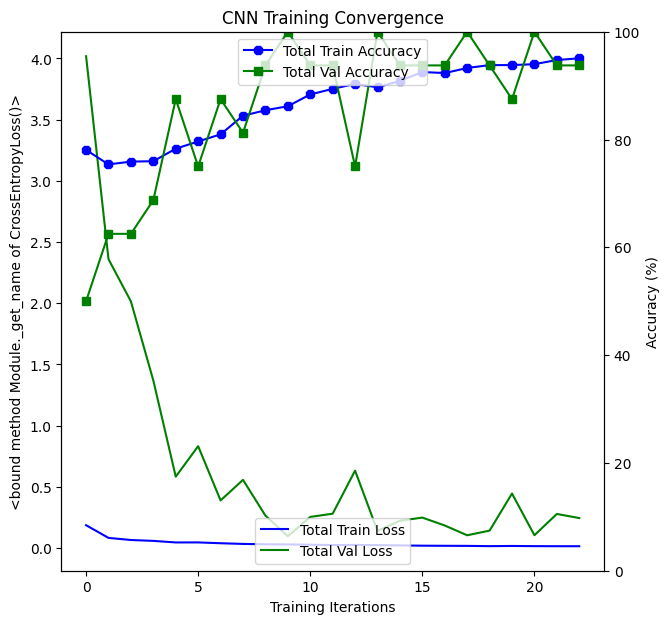

In [35]:
fig, ax1 = plt.subplots(figsize=(7, 7))
ax1.plot(total_loss_train, "b", label="Total Train Loss")
ax1.plot(total_loss_val, "g", label="Total Val Loss")
ax2.set_ylim(0, 5)
ax1.legend(loc=8)
ax2 = ax1.twinx()
ax2.plot(total_accuracy_train, "b", marker="8", label="Total Train Accuracy")
ax2.plot(total_accuracy_val, "g", marker="s", label="Total Val Accuracy")
ax2.set_ylim(0, 100)
ax2.legend(loc=9)
plt.title("CNN Training Convergence", color="black")
ax1.set_xlabel("Training Iterations")
ax1.set_ylabel(f"{criterion._get_name}", color="black")
ax2.set_ylabel("Accuracy (%)", color="black")
plt.show()

In [36]:
torch.save(model.state_dict(), "./Data/Model/model.pth")

#### Testing

In [37]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

In [38]:
model_pred = ImageClassifier()
model_pred.load_state_dict(torch.load("checkpoint.pt"))
model_pred.to(device)

ImageClassifier(
  (conv2D1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (conv2D2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (conv2D3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (conv2D4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (conv2D5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2D1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2D2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2D3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2D4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2D5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2D): Dropout2d(p=0.15, inplace=

Test Set


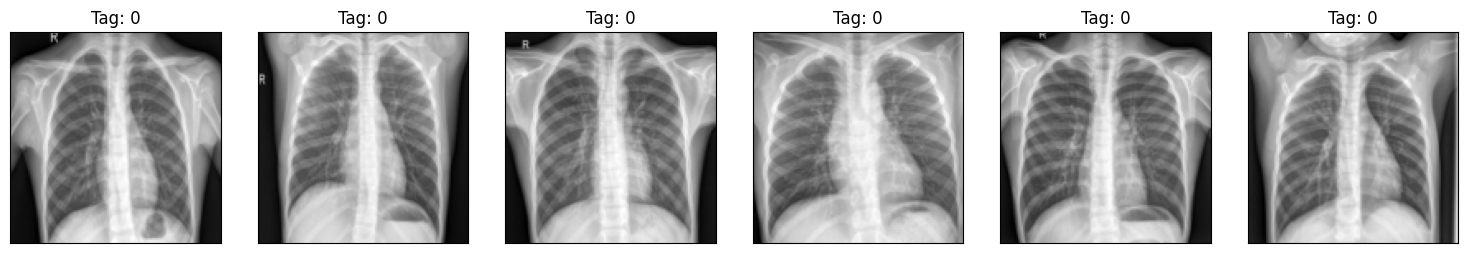

In [39]:
print("Test Set")
show_images(6, test_loader)

In [40]:
print(f"Classes: {test_dataset.class_to_idx}")
num_classes_test = Counter(test_dataset.targets)
print(f"Test DataSet: {num_classes_test}")

Classes: {'NORMAL': 0, 'PNEUMONIA': 1}
Test DataSet: Counter({1: 390, 0: 234})


In [41]:
def test(model, loader):
    model.eval()
    total_loss_test = []
    test_probs = []
    correct_test = 0
    pred = torch.Tensor().to(device)
    with torch.no_grad():
        for batch_idx, (image, target) in tqdm(
            enumerate(loader), desc="Test Epoch", total=len(loader)
        ):
            image = image.to(device)
            target = target.to(device)
            output = model(image)
            probs = torch.sigmoid(output)
            test_probs.extend(probs.cpu().numpy())
            loss = criterion(output, target)
            total_loss_test.append(loss.item())
            test_pred = output.argmax(dim=1, keepdim=False)
            correct_test += test_pred.eq(target).sum().item()
            pred = torch.cat((pred, test_pred), 0)
        return total_loss_test, correct_test, pred, test_probs

In [42]:
total_loss_test, correct_test, y_pred, probs_pred = test(model_pred, test_loader)

Test Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

#### Métricas

In [43]:
print(f"Loss Test: {(sum(total_loss_test) / len(total_loss_test)):.3f}")
print(f"Test Accuracy: {(100 * correct_test/ len(test_loader.dataset)):.2f} %")

Loss Test: 0.309
Test Accuracy: 87.66 %


In [44]:
y_pred = [int(pred) for pred in y_pred.cpu().numpy().tolist()]
prob_list = [list(array) for array in probs_pred]
prob_pos = [prob_list[i][1] for i in range(len(prob_list))]

In [45]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="g")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.show()

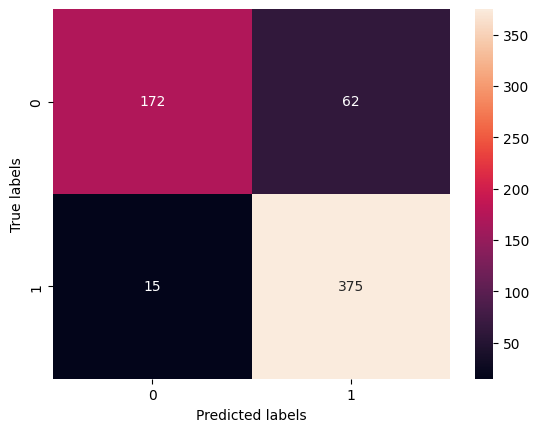

In [46]:
plot_confusion_matrix(test_dataset.targets, y_pred)

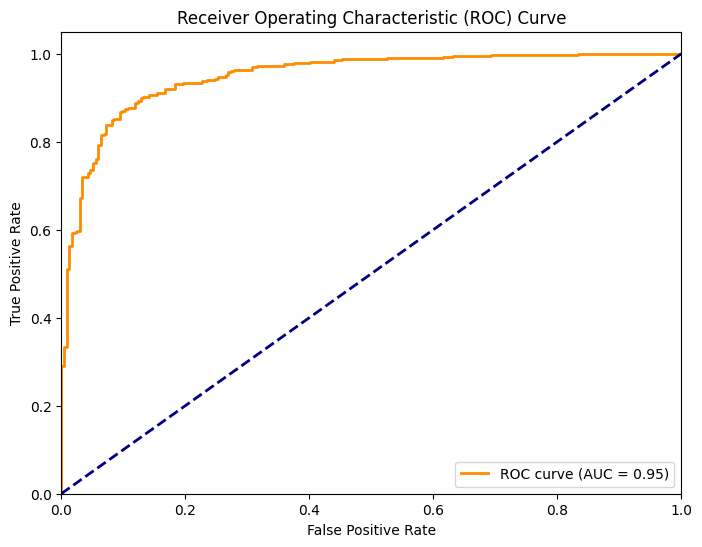

In [47]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(test_dataset.targets, prob_pos)

# Compute Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

### Calibración del Modelo

Que un modelo "no esté calibrado" significa que las probabilidades previstas por el modelo no se corresponden bien con la verdadera probabilidad de los resultados. En otras palabras, las probabilidades predichas no son un reflejo exacto de la realidad. 

La calibración es una medida del grado en que las probabilidades previstas de un suceso coinciden con los resultados reales de ese suceso.

**Importancia de la calibración**

Para muchas aplicaciones, especialmente en ámbitos sensibles al riesgo como la sanidad, las finanzas y la predicción meteorológica, es crucial no sólo predecir el resultado correcto, sino también proporcionar estimaciones de probabilidad fiables. Un modelo bien calibrado garantiza que cuando predice un suceso con, por ejemplo, un 70% de probabilidad, ese suceso ocurre realmente aproximadamente el 70% de las veces a lo largo de muchas predicciones.
Indicios de una calibración deficiente

* **Exceso de confianza:** Es posible que el modelo tenga un exceso de confianza en sus predicciones, emitiendo a menudo probabilidades cercanas a 0 o 1, pero los resultados reales no reflejan este nivel de certeza.
* **Falta de confianza:** A la inversa, un modelo puede tener poca confianza y predecir probabilidades demasiado conservadoras (por ejemplo, cercanas a 0,5 en una clasificación binaria), incluso cuando la clase correcta es bastante segura.
* **Probabilidades desajustadas:** De forma más general, existe un desajuste entre las probabilidades predichas y las frecuencias observadas. Por ejemplo, entre todas las instancias predichas con una probabilidad de 0,8, un número significativamente superior o inferior al 80% pertenece realmente a la clase predicha.

**Medición de la calibración**

* **Curva de calibración (diagrama de fiabilidad):** Compara la frecuencia real de un resultado con la probabilidad predicha. Un modelo perfectamente calibrado se situaría en la línea diagonal, lo que indica que las predicciones coinciden con las frecuencias reales.
* **Error de calibración esperado (ECE):** Proporciona un único valor numérico que representa la diferencia absoluta media entre las probabilidades predichas y las frecuencias de resultados reales en diferentes intervalos de probabilidades predichas.
* **Brier Score:** Mide la diferencia cuadrática media entre las probabilidades predichas y los resultados reales; las puntuaciones más bajas indican una mejor calibración.

Un modelo que no esté bien calibrado puede llevar a conclusiones erróneas o a decisiones equivocadas, sobre todo si las probabilidades se utilizan para evaluar riesgos o tomar decisiones críticas. Por lo tanto, evaluar y mejorar la calibración es un paso esencial para desarrollar modelos predictivos fiables.

Ejemplo:

Consideremos un ejemplo de modelo no bien calibrado en el contexto del diagnóstico médico, concretamente la predicción de la probabilidad de que los pacientes padezcan una determinada enfermedad a partir de pruebas diagnósticas y otros indicadores de salud. Este modelo es un clasificador binario que emite una puntuación de probabilidad entre 0 y 1, donde 1 indica la presencia de la enfermedad.

**Modelo de diagnóstico médico**

Rendimiento del modelo: Alta precisión y área bajo la curva ROC (AUC), lo que indica un buen poder discriminatorio entre pacientes sanos y enfermos.

Sin embargo, al examinar la calibración del modelo, se observa que para los pacientes a los que el modelo asigna una probabilidad de enfermedad del 70%, la tasa real de presencia de enfermedad en este grupo es sólo del 40%.

**Repercusiones de una calibración deficiente:**

La confianza de los pacientes y planes de tratamiento puede verse alterada:

* **Sobreestimación del riesgo:** Se puede informar a los pacientes de que tienen un alto riesgo de padecer la enfermedad (por ejemplo, un 70% de probabilidad) cuando, en realidad, la probabilidad real es mucho menor (por ejemplo, un 40%). Esta sobreestimación puede provocar ansiedad innecesaria, más pruebas invasivas o incluso un tratamiento prematuro, que podría tener sus propios efectos secundarios y costes.
* **Subestimación del riesgo:** Por el contrario, si el modelo subestima el riesgo en determinados casos, algunos pacientes podrían no recibir la atención o el seguimiento que necesitan, lo que podría empeorar su salud.

**Asignación de recursos sanitarios:**

Las puntuaciones de probabilidad engañosas podrían conducir a un uso ineficiente de los recursos sanitarios, dirigiéndolos hacia pacientes que podrían no necesitar cuidados inmediatos o intensivos, mientras que los que realmente los necesitan podrían no recibir la intervención oportuna.

**Orientación política y de salud pública:**

A un nivel más amplio, si un modelo de este tipo se utiliza para la planificación o la elaboración de políticas de salud pública, una calibración deficiente podría orientar erróneamente las respuestas de salud pública, dar lugar a una asignación incorrecta de fondos o afectar al desarrollo de directrices para la prevención y la gestión de enfermedades.



**Problemas de calibración:**

En el caso del modelo de diagnóstico médico, es fundamental mejorar la calibración para garantizar que las probabilidades previstas reflejen con exactitud la verdadera probabilidad de presencia de la enfermedad. Técnicas como el escalado de temperatura, el escalado de Platt o la regresión isotónica pueden emplearse tras el entrenamiento del modelo para ajustar las puntuaciones de probabilidad. Además, la incorporación de un análisis gráfico de calibración en el proceso de evaluación del modelo puede ayudar a identificar y corregir los problemas de calibración antes de desplegar el modelo.

Un modelo mal calibrado, especialmente en aplicaciones críticas como el diagnóstico médico, puede tener repercusiones importantes, como pacientes mal informados, un uso ineficiente de los recursos sanitarios y decisiones políticas equivocadas. Una calibración adecuada garantiza que las puntuaciones de probabilidad sean significativas y fiables, lo que permite mejorar los procesos de toma de decisiones.

In [48]:
metrics = [
    "Accuracy",
    "Precision",
    "Recall",
    "F1",
    "ROC AUC",
    "ECE",
    "Log Loss",
    "Brier Loss",
]

perf_df = pd.DataFrame(columns=metrics)

In [49]:
def evaluate_model_performance(
    model_name, targets, predictions, prob_pos, perf_df, verbose
):
    """
    Evaluates model performance and updates the performance dataframe with metrics.
    """

    # Compute metrics
    accuracy = accuracy_score(targets, predictions)
    precision = precision_score(targets, predictions, zero_division=0)
    recall = recall_score(targets, predictions)
    f1 = f1_score(targets, predictions)
    roc_auc = roc_auc_score(targets, prob_pos)
    logloss = log_loss(targets, prob_pos)
    brier_loss = brier_score_loss(targets, prob_pos)

    # Compute Expected Calibration Error (ECE)
    fraction_of_positives, mean_predicted_value = calibration_curve(
        targets, prob_pos, n_bins=20, strategy="uniform"
    )
    ece = np.sum(np.abs(fraction_of_positives - mean_predicted_value)) / len(
        mean_predicted_value
    )

    # Populate the performance dataframe
    perf_df.loc[model_name, :] = [
        accuracy,
        precision,
        recall,
        f1,
        roc_auc,
        ece,
        logloss,
        brier_loss,
    ]

    # Plot Calibration Curve and Histogram if verbose is True
    if verbose:
        fig = plt.figure(figsize=(10, 10))
        gs = GridSpec(2, 1)
        ax_calibration_curve = fig.add_subplot(gs[0, :])
        ax_histogram = fig.add_subplot(gs[1, :])

        # Plot Calibration Curve
        ax_calibration_curve.plot(
            mean_predicted_value, fraction_of_positives, '-s', label=model_name
        )
        ax_calibration_curve.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
        ax_calibration_curve.set_title(f"Calibration plot ({model_name})")
        ax_calibration_curve.set_xlabel("Mean predicted probability")
        ax_calibration_curve.set_ylabel("Fraction of positives")
        ax_calibration_curve.legend()

        # Plot Histogram
        ax_histogram.hist(
            prob_pos, range=(0, 1), bins=20, label=model_name)
        ax_histogram.set_title(f"Probability Distribution ({model_name})")
        ax_histogram.set_xlabel("Mean predicted probability")
        ax_histogram.set_ylabel("Count")
        plt.tight_layout()
        plt.show()

    return perf_df

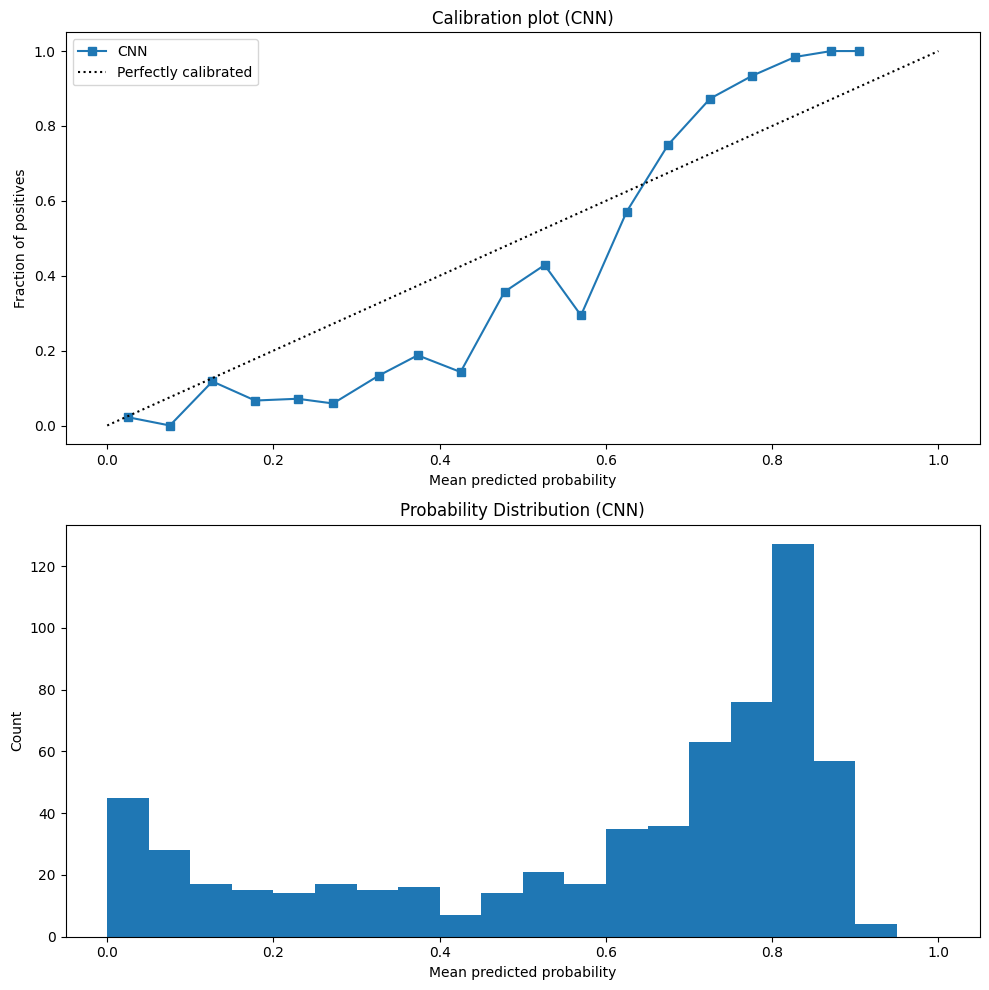

Accuracy Precision    Recall        F1   ROC AUC       ECE  Log Loss  \
CNN  0.876603  0.858124  0.961538  0.906892  0.949233  0.133696  0.352179   

    Brier Loss  
CNN   0.102413

In [50]:
evaluate_model_performance(
    "CNN", test_dataset.targets, y_pred, prob_pos, perf_df, verbose=True
)

**Análisis**

Precisión (Accuracy)

0.847756: Indica que el modelo predice correctamente el 84.78% de las veces. Es una medida general de cuántas predicciones fueron correctas.

Precisión (Precision)

0.813163: Muestra que cuando el modelo predice la clase positiva, es correcto el 81.32% de las veces. La precisión es importante cuando el costo de un falso positivo es alto.

Recall (Recuperación)

0.982051: Indica que el modelo es capaz de identificar el 98.21% de todas las instancias reales de la clase positiva. El recall es crucial cuando es importante detectar todos los casos positivos.

Puntaje F1 (F1 Score)

0.889663: Es el promedio armónico de la precisión y el recall, ofreciendo un balance entre estas dos métricas. Un puntaje F1 de 88.97% es bastante alto, indicando un buen equilibrio.

ROC AUC

0.936347: Representa el Área Bajo la Curva de Características Operativas del Receptor (ROC AUC). Un valor de 93.63% sugiere que el modelo tiene una excelente capacidad para distinguir entre las clases positiva y negativa.

ECE (Expected Calibration Error)

0.197762: El Error de Calibración Esperado de 19.78% indica una discrepancia entre las probabilidades predichas y los resultados reales. Cuanto menor sea este valor, mejor calibrado está el modelo.

Log Loss (Pérdida Logarítmica)

0.353958: Esta métrica cuantifica la precisión de las probabilidades predichas. Un valor más bajo indica mejores predicciones. Una pérdida logarítmica de 0.354 sugiere que, en promedio, las probabilidades estimadas están moderadamente bien alineadas con las etiquetas reales.

Brier Loss (Pérdida de Brier)

0.105195: Mide el error cuadrático medio de las probabilidades predichas. Un valor de 0.105 indica un buen nivel de precisión en las probabilidades predichas, con valores más bajos representando mejores predicciones.

**Interpretación General**

El modelo CNN muestra un rendimiento sólido en términos de precisión, recall y F1, indicando un buen equilibrio entre la capacidad de identificar correctamente los casos positivos y la precisión de esas identificaciones. 

La alta puntuación ROC AUC revela una excelente capacidad discriminativa. 

Sin embargo, el ECE relativamente alto sugiere que hay espacio para mejorar la calibración de las probabilidades predichas para que coincidan más estrechamente con las frecuencias reales. La pérdida logarítmica y la pérdida de Brier también apoyan esta visión, indicando una buena, pero mejorable, confianza en las probabilidades estimadas.

### Ejercicio 

* Proponer mejoras para el modelo, en caso de ser posible.

### Referencias

* What is the Convolutional Neural Network Architecture?: https://www.analyticsvidhya.com/blog/2020/10/what-is-the-convolutional-neural-network-architecture/

![Lenguaje Matemático](./Images/Matematicas.png)

![Contacto](./Images/Contacto.png)